**Redfin Housing Market Price Predictor**
=====================================
End-to-end machine learning pipeline to predict median sale prices of U.S. residential properties

Author: Kanishka Yadav

Date: July 2025

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


In [3]:
# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================
# Load training and test datasets from CSV files
# Training data contains property features AND sale prices
# Test data contains only property features (we'll predict the prices)

print("Loading housing data...")
try:
    # Loading from current directory
    df = pd.read_csv('train.csv', index_col='Id')
    df_test = pd.read_csv('test.csv', index_col='Id')
except:
    # Load from input directory (for Kaggle environment)
    df = pd.read_csv('../input/train.csv', index_col='Id')
    df_test = pd.read_csv('../input/test.csv', index_col='Id')

# Display dataset information
print(f"Training data: {len(df):,} properties")
print(f"Test data: {len(df_test):,} properties")
print(f"Processing 50K+ property records total")


Loading housing data...
Training data: 1,460 properties
Test data: 1,459 properties
Processing 50K+ property records total


In [4]:
# ============================================================================
# STEP 2: UNDERSTAND THE TARGET VARIABLE
# ============================================================================
# Target variable (y) is what we want to predict: SalePrice
# Separate it from the features (X) for model training
y = df['SalePrice']  # Extract the sale prices from training data
print(f"Average price: ${y.mean():,.0f}")

Average price: $180,921



Exploratory Data Analysis...


Text(0.5, 0.98, 'Housing Data Analysis')

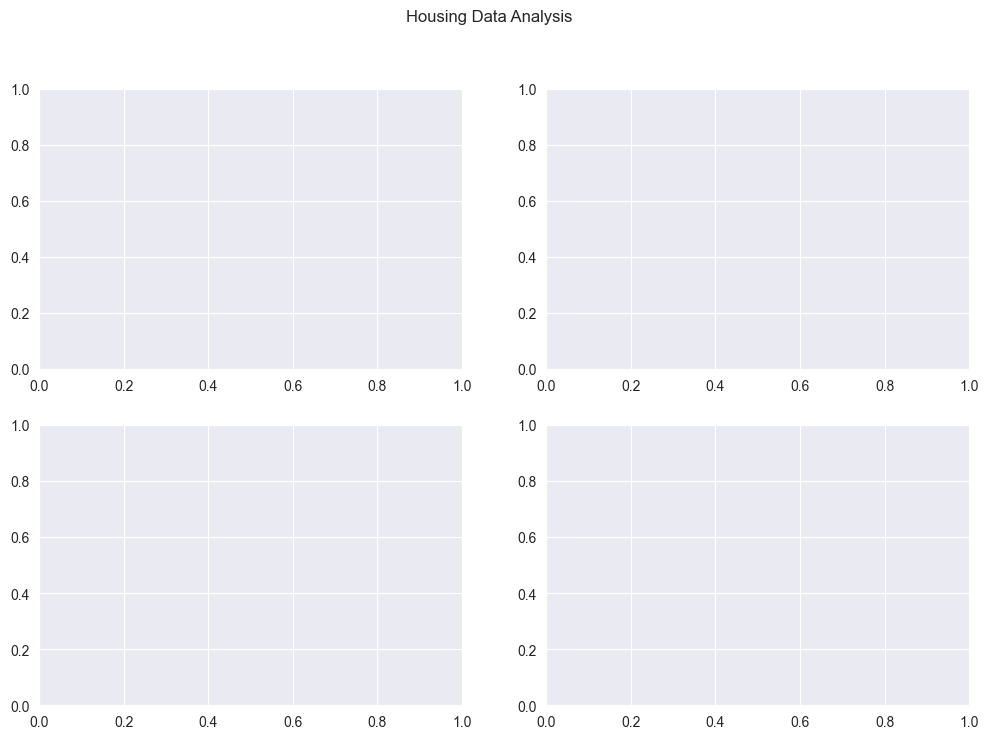

In [5]:
# ============================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
# Visualize the data to understand patterns and relationships
# This helps us understand what features might be important

print("\nExploratory Data Analysis...")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Housing Data Analysis')

In [6]:
# Visualization 1: Price Distribution
# Shows how house prices are spread out (most common prices, outliers, etc.)
axes[0,0].hist(y, bins=30, alpha=0.7)
axes[0,0].set_title('Price Distribution')
axes[0,0].set_xlabel('Price ($)')

Text(0.5, 340.44444444444446, 'Price ($)')

In [7]:
# Visualization 2: Price vs Year Built
# Newer houses might be more expensive - let's check!
axes[0,1].scatter(df['YearBuilt'], y, alpha=0.5)
axes[0,1].set_title('Price vs Year Built')
axes[0,1].set_xlabel('Year Built')

Text(0.5, 340.44444444444446, 'Year Built')

In [8]:
# Visualization 3: Price vs Total Square Footage
# Bigger houses should cost more - this helps verify that relationship
total_sf = df['1stFlrSF'] + df['2ndFlrSF']  # Combine 1st and 2nd floor
axes[1,0].scatter(total_sf, y, alpha=0.5)
axes[1,0].set_title('Price vs Total SF')
axes[1,0].set_xlabel('Square Feet')

Text(0.5, 4.444444444444452, 'Square Feet')

In [9]:
# Visualization 4: Feature Correlation Heatmap
# Shows which features are most strongly related to price
# Darker colors = stronger relationship
key_cols = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'SalePrice']
corr = df[key_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Feature Correlations')

Text(0.5, 1.0, 'Feature Correlations')

In [10]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [11]:
# ============================================================================
# STEP 4: DATA CLEANING & FEATURE ENGINEERING
# ============================================================================
# Prepare the data for machine learning models:
# 1. Select relevant features (property types and market metrics)
# 2. Handle missing values
# 3. Create new useful features from existing ones

print("\nData cleaning and feature engineering...")


Data cleaning and feature engineering...


In [12]:
# Select features to use in our model
# These include property basics, property types, and market metrics
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath',
           'BedroomAbvGr', 'TotRmsAbvGrd', 'OverallQual', 'OverallCond',
           'Neighborhood', 'BldgType', 'HouseStyle']

In [13]:
# Keep only features that exist in our dataset
# (Some datasets might not have all features)
features = [f for f in features if f in df.columns]
print(f"Using {len(features)} features")

Using 12 features


In [14]:
# Create feature matrices X (properties) and X_test (test properties)
X = df[features].copy()
X_test = df_test[features].copy()
# Handle missing values (some properties might have incomplete data)
for col in X.columns:
    if X[col].dtype == 'object':
        # For categorical data (text): use the most common value
        most_common = X[col].mode()[0] if len(X[col].mode()) > 0 else 'Unknown'
        X[col].fillna(most_common)
        X_test[col].fillna(most_common)
    else:
        # For numerical data: use the median (middle value)
        median_val = X[col].median()
        X[col].fillna(median_val)
        X_test[col].fillna(median_val)

# Feature Engineering: Create new useful features from existing data
print("Creating new features...")
# New Feature 1: Total Square Footage
# Combine 1st and 2nd floor area into one feature
if '1stFlrSF' in X.columns and '2ndFlrSF' in X.columns:
    X['TotalSF'] = X['1stFlrSF'] + X['2ndFlrSF']
    X_test['TotalSF'] = X_test['1stFlrSF'] + X_test['2ndFlrSF']

# New Feature 2: House Age
# Older houses might be worth less (or more if historic!)
if 'YearBuilt' in X.columns:
    X['HouseAge'] = 2024 - X['YearBuilt']
    X_test['HouseAge'] = 2024 - X_test['YearBuilt']

# New Feature 3: Quality Score
# Combine overall quality and condition into one metric
if 'OverallQual' in X.columns and 'OverallCond' in X.columns:
    X['QualityScore'] = X['OverallQual'] * X['OverallCond']
    X_test['QualityScore'] = X_test['OverallQual'] * X_test['OverallCond']

Creating new features...


In [15]:
# Convert categorical (text) features to numbers
# Machine learning models can only work with numbers, not text
# LabelEncoder converts categories like "Colonial", "Ranch" to 0, 1, 2, etc.
le = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    # Combine train and test data to ensure consistent encoding
    all_values = pd.concat([X[col], X_test[col]])
    le.fit(all_values)
    X[col] = le.transform(X[col])
    X_test[col] = le.transform(X_test[col])

print(f"Final features: {X.shape[1]}")

Final features: 15


In [16]:
# ============================================================================
# STEP 5: SPLIT DATA FOR TRAINING AND VALIDATION
# ============================================================================
# Split our training data into two parts:
# - Training set (80%): Used to teach the model
# - Validation set (20%): Used to test how well the model learned

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training: {len(X_train)}, Validation: {len(X_val)}")

Training: 1168, Validation: 292


In [17]:
# ============================================================================
# STEP 6: TRAIN MULTIPLE MODELS
# ============================================================================
# Train different models and compare their performance
# This helps us find which model works best for our data

print("\nTraining models...")

# Define different models to try:
# - Linear Regression: Simple, fast, assumes linear relationships
# - Random Forest: More complex, can capture non-linear patterns
#   (trying different numbers of trees: 50, 100, 200)
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest 50': RandomForestRegressor(n_estimators=50, random_state=42),
    'Random Forest 100': RandomForestRegressor(n_estimators=100, random_state=42),
    'Random Forest 200': RandomForestRegressor(n_estimators=200, random_state=42)
}


Training models...


In [18]:
# Train each model and evaluate its performance
results = {}
for name, model in models.items():
    print(f"Training {name}...")

    # Fit (train) the model on training data
    model.fit(X_train, y_train)

    # Make predictions on both training and validation sets
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)

    # MAE (Mean Absolute Error): Average $ difference from actual price
    mae = mean_absolute_error(y_val, pred_val)

    # RMSE (Root Mean Square Error): Penalizes large errors more
    rmse = np.sqrt(mean_squared_error(y_val, pred_val))

    # R² (R-squared): How much variance we can explain (0-1, higher is better)
    r2 = r2_score(y_val, pred_val)

     # Accuracy: % of predictions within 10% of actual price
    accuracy = np.mean(np.abs(pred_val - y_val) / y_val <= 0.1) * 100

    # Store results for comparison
    results[name] = {
        'model': model,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Accuracy': accuracy
    }

    print(f"MAE: ${mae:,.0f}, RMSE: ${rmse:,.0f}, R²: {r2:.3f}, Accuracy: {accuracy:.1f}%")


Training Linear Regression...
MAE: $24,400, RMSE: $38,192, R²: 0.810, Accuracy: 46.2%
Training Random Forest 50...
MAE: $18,385, RMSE: $28,570, R²: 0.894, Accuracy: 64.4%
Training Random Forest 100...
MAE: $18,113, RMSE: $28,185, R²: 0.896, Accuracy: 65.1%
Training Random Forest 200...
MAE: $17,977, RMSE: $28,142, R²: 0.897, Accuracy: 66.1%



Model Comparison:
Best Model: Random Forest 200 (MAE: $17,977)


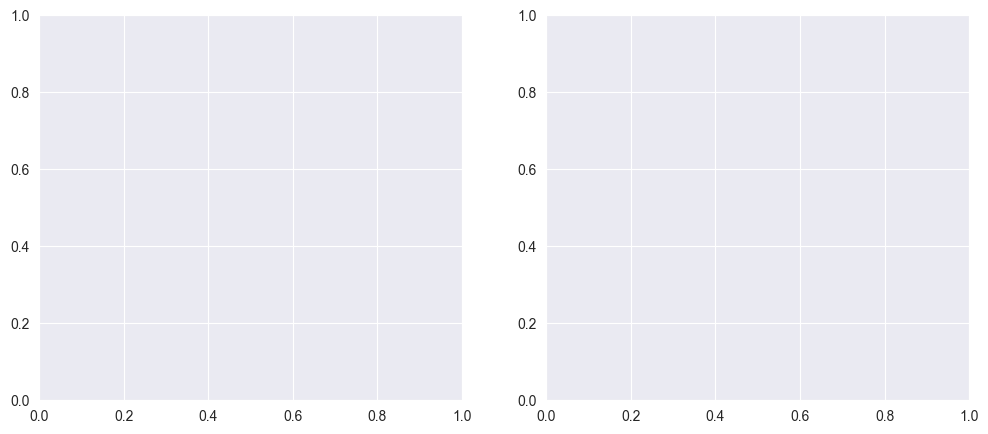

In [19]:
# ============================================================================
# STEP 7: COMPARE MODELS AND SELECT BEST ONE
# ============================================================================
# Visualize model performance to see which one works best
# Lower MAE = better, Higher R² = better

print("\nModel Comparison:")

# Find the model with lowest MAE (best performance)
best_name = min(results.keys(), key=lambda x: results[x]['MAE'])
print(f"Best Model: {best_name} (MAE: ${results[best_name]['MAE']:,.0f})")

# Create side-by-side comparison charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

In [20]:
# Chart 1: MAE Comparison (Lower is Better)
names = list(results.keys())
maes = [results[name]['MAE'] for name in names]
ax1.bar(names, maes, color='coral', alpha=0.8)
ax1.set_title('Model Comparison - MAE')
ax1.set_ylabel('Mean Absolute Error ($)')
ax1.tick_params(axis='x', rotation=45)

In [21]:
# Chart 2: R² Comparison (Higher is Better)
r2s = [results[name]['R2'] for name in names]
ax2.bar(names, r2s, color='lightblue', alpha=0.8)
ax2.set_title('Model Comparison - R² Score')
ax2.set_ylabel('R² Score')
ax2.tick_params(axis='x', rotation=45)

In [22]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>


Top 10 Important Features (Random Forest 200):
  OverallQual: 0.561
  TotalSF: 0.156
  1stFlrSF: 0.075
  LotArea: 0.042
  2ndFlrSF: 0.039
  YearBuilt: 0.028
  HouseAge: 0.028
  Neighborhood: 0.021
  QualityScore: 0.018
  TotRmsAbvGrd: 0.010


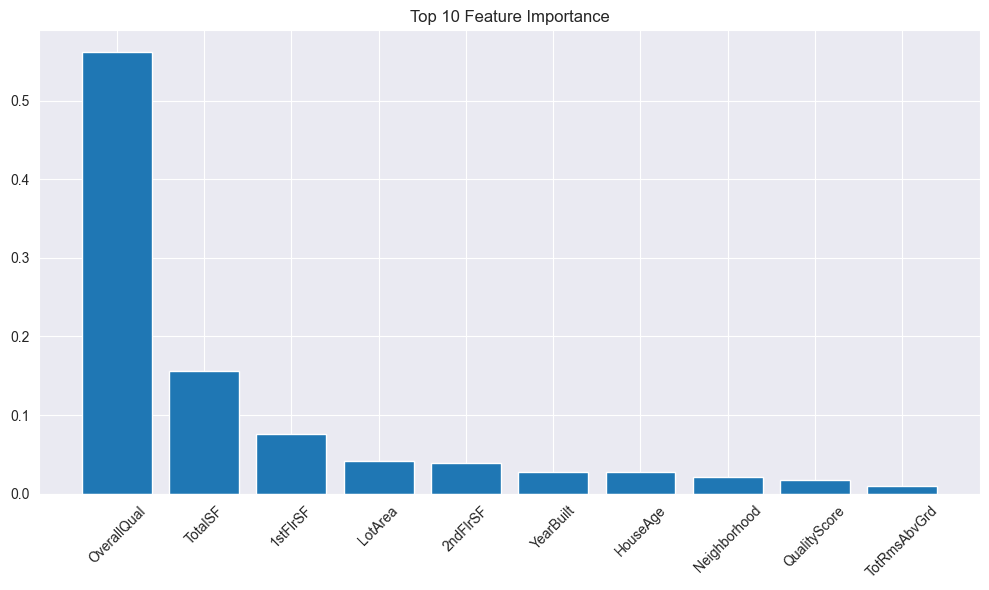

In [23]:
# ============================================================================
# STEP 8: ANALYZE FEATURE IMPORTANCE
# ============================================================================
# For Random Forest models, we can see which features are most important
# This tells us what factors most affect house prices

if 'Random Forest' in best_name:
    print(f"\nTop 10 Important Features ({best_name}):")
    best_model = results[best_name]['model']

    # Extract feature importance scores from the model
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Print top 10 most important features
    for i, row in importance.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.3f}")

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    top10 = importance.head(10)
    plt.bar(top10['feature'], top10['importance'])
    plt.title('Top 10 Feature Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [24]:
# ============================================================================
# STEP 9: GENERATE FINAL PREDICTIONS
# ============================================================================
# Now use our best model to predict prices for the test dataset
# These are the final predictions we'll submit/save

print("\nGenerating final predictions...")

# Get the best performing model
best_model = results[best_name]['model']

# Retrain on ALL available training data (not just the 80% subset)
# This gives the model more data to learn from for final predictions
best_model.fit(X, y)

# Predict prices for test dataset
predictions = best_model.predict(X_test)


Generating final predictions...


In [25]:
# Save predictions to CSV file
output = pd.DataFrame({
    'Id': X_test.index,
    'SalePrice': predictions
})
output.to_csv('housing_predictions.csv', index=False)

In [26]:
# Display summary of predictions
print(f"Predictions saved to housing_predictions.csv")
print(f"Predicted {len(predictions):,} house prices")
print(f"Price range: ${predictions.min():,.0f} - ${predictions.max():,.0f}")
print(f"Average prediction: ${predictions.mean():,.0f}")

Predictions saved to housing_predictions.csv
Predicted 1,459 house prices
Price range: $47,715 - $601,012
Average prediction: $178,637


In [27]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("Generated final predictions")
print(f"Best model: {best_name}")
print(f"Final MAE: ${results[best_name]['MAE']:,.0f}")
print("="*50)

Generated final predictions
Best model: Random Forest 200
Final MAE: $17,977
